<a href="https://colab.research.google.com/github/mintycake420/Basic-Exercises-for-courses/blob/main/InformationRetreival_EX02_211718366.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Wikipedia Article Analyzer with BM25 Ranking**

This project:
1. Fetches 10 random Wikipedia articles
2. Saves articles and analyzes word frequencies
3. Accepts 4 search terms from the user
4. Ranks documents using **Okapi BM25 algorithm** (k1=1.6, b=0.75)
5. Visualizes results with **Pandas DataFrames**:
   - Table 1: Term frequencies (occurrences per document)
   - Table 2: BM25 scores (ranked by relevance)


**Submitted by:** Yotam Katz  
**Date:** 13.11.2025  
**Course:** אחזור מידע 26 3700 א01  
**Lecturer:** Dr. Moshe Friedman  
**ID:** 211718366  
**Email:** Yotamkatz2000@gmail.com

In [70]:
# Install and import required libraries
!pip install wikipedia

import wikipedia
import re
from collections import Counter
import os
from google.colab import drive
import pandas as pd
import numpy as np
import math
from IPython.display import display, HTML
import matplotlib.pyplot as plt

In [60]:
# Text cleaning function
def clean_text(text):
    """Remove special characters and convert to lowercase"""
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    text = text.lower()
    words = text.split()
    return words

In [61]:
# Fetch Wikipedia articles
def fetch_articles(num_articles=10):
    """Fetch random articles from Wikipedia"""
    articles = []
    print("Fetching articles from Wikipedia...")

    attempts = 0
    max_attempts = num_articles * 3

    while len(articles) < num_articles and attempts < max_attempts:
        attempts += 1
        try:
            page_title = wikipedia.random(1)
            print(f"Trying: {page_title}")

            page = wikipedia.page(page_title, auto_suggest=False)

            if len(page.content) > 500:
                articles.append({
                    'title': page.title,
                    'content': page.content
                })
                print(f"✓ Added article {len(articles)}/{num_articles}: {page.title}")
            else:
                print(f"✗ Article too short, trying another...")

        except wikipedia.exceptions.DisambiguationError:
            print(f"✗ Disambiguation page, skipping...")
        except wikipedia.exceptions.PageError:
            print(f"✗ Page not found, skipping...")
        except Exception as e:
            print(f"✗ Error: {e}")

    return articles

In [62]:
# Save articles to files
def save_articles_to_files(articles, directory):
    """Save each article to a separate text file"""
    if not os.path.exists(directory):
        os.makedirs(directory)

    print(f"\nSaving articles to '{directory}' directory...")

    for i, article in enumerate(articles, 1):
        filename = f"{directory}/article_{i}.txt"
        with open(filename, 'w', encoding='utf-8') as f:
            f.write(f"Title: {article['title']}\n\n")
            f.write(article['content'])
        print(f"Saved: {filename}")

In [63]:
# Analyze word frequencies
def analyze_word_frequency(articles, top_n=50):
    """Count word frequencies across all articles"""
    print("\nAnalyzing word frequencies...")

    all_words = []
    for article in articles:
        words = clean_text(article['content'])
        all_words.extend(words)

    word_counts = Counter(all_words)
    most_common = word_counts.most_common(top_n)

    return most_common, len(all_words)

def save_word_frequencies(most_common, total_words, filename):
    """Save the most common words to a file"""
    print(f"\nSaving word frequencies to '{filename}'...")

    with open(filename, 'w', encoding='utf-8') as f:
        f.write("50 MOST COMMON WORDS\n")
        f.write("=" * 50 + "\n\n")
        f.write(f"Total words analyzed: {total_words}\n\n")
        f.write(f"{'Rank':<6} {'Word':<20} {'Count':<10}\n")
        f.write("-" * 50 + "\n")

        for rank, (word, count) in enumerate(most_common, 1):
            f.write(f"{rank:<6} {word:<20} {count:<10}\n")

    print(f"✓ Word frequencies saved")

In [64]:
# Compute term frequencies (Table 1)
def compute_term_frequencies(articles, terms):
    """
    Compute term frequency (TF) for each term in each document
    Returns: DataFrame with rows=documents, columns=terms
    """
    tf_data = []

    for i, article in enumerate(articles):
        words = clean_text(article['content'])
        word_counts = Counter(words)

        row = {'Document': f"Doc {i+1} ({article['title'][:30]}...)"}
        for term in terms:
            row[term] = word_counts.get(term.lower(), 0)

        tf_data.append(row)

    return pd.DataFrame(tf_data)

In [65]:
# Compute BM25 scores (Table 2)
def compute_bm25_scores(articles, terms, k1=1.6, b=0.75):
    """
    Compute BM25 scores for each term in each document

    Parameters:
    - k1: controls term frequency saturation (default 1.6)
    - b: controls document length normalization (default 0.75)

    Returns: DataFrame with BM25 scores and ranking
    """
    N = len(articles)

    # Prepare document data
    doc_lengths = []
    doc_term_freqs = []

    for article in articles:
        words = clean_text(article['content'])
        doc_lengths.append(len(words))
        doc_term_freqs.append(Counter(words))

    avgdl = sum(doc_lengths) / len(doc_lengths)

    # Calculate document frequency (df) for each term
    df = {}
    for term in terms:
        term_lower = term.lower()
        df[term_lower] = sum(1 for wc in doc_term_freqs if term_lower in wc)

    # Calculate BM25 scores
    bm25_data = []

    for i, article in enumerate(articles):
        doc_length = doc_lengths[i]
        word_counts = doc_term_freqs[i]

        row = {'Document': f"Doc {i+1} ({article['title'][:30]}...)"}
        total_score = 0

        for term in terms:
            term_lower = term.lower()
            tf = word_counts.get(term_lower, 0)
            df_term = df[term_lower]

            # IDF calculation
            if df_term > 0:
                idf = math.log((N - df_term + 0.5) / (df_term + 0.5) + 1.0)
            else:
                idf = 0

            # BM25 formula
            numerator = tf * (k1 + 1)
            denominator = tf + k1 * (1 - b + b * (doc_length / avgdl))

            if denominator != 0:
                bm25_score = idf * (numerator / denominator)
            else:
                bm25_score = 0

            row[term] = round(bm25_score, 4)
            total_score += bm25_score

        row['Total BM25 Score'] = round(total_score, 4)
        bm25_data.append(row)

    # Sort by total score
    df_bm25 = pd.DataFrame(bm25_data)
    df_bm25 = df_bm25.sort_values('Total BM25 Score', ascending=False).reset_index(drop=True)
    df_bm25.insert(0, 'Rank', range(1, len(df_bm25) + 1))

    return df_bm25

In [66]:
# Get search terms from user
def get_user_terms():
    """Get 4 search terms from the user"""
    print("\n" + "=" * 60)
    print("SEARCH TERM INPUT")
    print("=" * 60)
    print("Please enter 4 search terms (one at a time):")

    terms = []
    for i in range(4):
        while True:
            term = input(f"Term {i+1}: ").strip()
            if term:
                terms.append(term)
                break
            else:
                print("  ⚠️  Term cannot be empty. Please try again.")

    return terms

In [73]:
# Display results
def display_results(df_tf, df_bm25, terms):
    """Display the results with Pandas DataFrames and a chart"""
    print("\n" + "=" * 80)
    print("RESULTS")
    print("=" * 80)

    print(f"\nSearch Terms: {', '.join(terms)}")

    print("\n" + "-" * 80)
    print("TABLE 1: TERM FREQUENCIES (Number of occurrences)")
    print("-" * 80)
    display(df_tf)

    # Plotting term frequencies
    print("\n" + "=" * 80)
    print("TERM FREQUENCY VISUALIZATION")
    print("=" * 80)

    # Prepare data for plotting
    df_tf_plot = df_tf.set_index('Document').drop('Document', axis=1, errors='ignore') # Ensure 'Document' column is dropped if it somehow made it to the index after set_index
    df_tf_plot = df_tf_plot[terms] # Select only the term columns

    if not df_tf_plot.empty:
        ax = df_tf_plot.plot(kind='bar', figsize=(14, 7), width=0.8)
        plt.title('Term Frequencies per Document')
        plt.xlabel('Document')
        plt.ylabel('Number of Occurrences')
        plt.xticks(rotation=45, ha='right')
        plt.legend(title='Terms', bbox_to_anchor=(1.05, 1), loc='upper left')
        plt.tight_layout()
        plt.show()
    else:
        print("No term frequency data to plot.")

    print("\n" + "-" * 80)
    print("TABLE 2: BM25 SCORES (Ranked by relevance)")
    print("Parameters: k1=1.6, b=0.75")
    print("-" * 80)
    display(df_bm25)

    print("\n" + "=" * 80)
    print("RANKING SUMMARY")
    print("=" * 80)
    for i, row in df_bm25.iterrows():
        print(f"{row['Rank']}. {row['Document']} - Score: {row['Total BM25 Score']}")

    # Plotting the BM25 scores
    print("\n" + "=" * 80)
    print("BM25 SCORE VISUALIZATION")
    print("=" * 80)

    plt.figure(figsize=(12, 6))
    # Ensure documents are in the correct order for plotting (by rank)
    df_bm25_plot = df_bm25.set_index('Document').sort_values('Rank', ascending=True)
    df_bm25_plot['Total BM25 Score'].plot(kind='bar')
    plt.title('BM25 Scores per Document (Ranked by Relevance)')
    plt.xlabel('Document')
    plt.ylabel('Total BM25 Score')
    plt.xticks(rotation=45, ha='right') # Rotate x-axis labels for readability
    plt.tight_layout() # Adjust layout to prevent labels from overlapping
    plt.show()

In [68]:
# Save BM25 results
def save_bm25_results(df_tf, df_bm25, terms, output_path):
    """Save BM25 results to CSV and text files"""
    print(f"\n\nSaving BM25 results...")

    # Save term frequencies
    tf_file = f"{output_path}/term_frequencies.csv"
    df_tf.to_csv(tf_file, index=False)
    print(f"✓ Term frequencies: {tf_file}")

    # Save BM25 scores
    bm25_file = f"{output_path}/bm25_scores.csv"
    df_bm25.to_csv(bm25_file, index=False)
    print(f"✓ BM25 scores: {bm25_file}")

    # Save summary
    summary_file = f"{output_path}/bm25_summary.txt"
    with open(summary_file, 'w', encoding='utf-8') as f:
        f.write("BM25 RANKING RESULTS\n")
        f.write("=" * 60 + "\n\n")
        f.write(f"Search Terms: {', '.join(terms)}\n")
        f.write(f"Parameters: k1=1.6, b=0.75\n\n")
        f.write("RANKING:\n")
        f.write("-" * 60 + "\n")
        for i, row in df_bm25.iterrows():
            f.write(f"{row['Rank']}. {row['Document']}\n")
            f.write(f"   Score: {row['Total BM25 Score']}\n\n")
    print(f"✓ Summary: {summary_file}")

Wikipedia Article Analyzer with BM25 Ranking

Mounting Google Drive...
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
✓ Output directory ready: /content/drive/MyDrive/Colab Notebooks/Information Retreival
Fetching articles from Wikipedia...
Trying: Camille Hurel
✓ Added article 1/10: Camille Hurel
Trying: Terminus Saint-Eustache
✗ Article too short, trying another...
Trying: Jaw jerk reflex
✓ Added article 2/10: Jaw jerk reflex
Trying: Françoise Gravillon
✓ Added article 3/10: Françoise Gravillon
Trying: Boloria polaris
✓ Added article 4/10: Boloria polaris
Trying: John Oldrid Scott
✓ Added article 5/10: John Oldrid Scott
Trying: Drum Tower of Nanjing
✓ Added article 6/10: Drum Tower of Nanjing
Trying: Tom Root
✓ Added article 7/10: Tom Root
Trying: Marion Wadsworth Cannon
✓ Added article 8/10: Marion Wadsworth Cannon
Trying: Purple roller
✓ Added article 9/10: Purple roller
Trying: William K. Clowney
✓ A

,Document,purple,william,John,the
0,Doc 1 (Camille Hurel...),0,0,0,4
1,Doc 2 (Jaw jerk reflex...),0,0,0,50
2,Doc 3 (Françoise Gravillon...),0,0,0,10
3,Doc 4 (Boloria polaris...),0,0,0,27
4,Doc 5 (John Oldrid Scott...),0,0,9,37
5,Doc 6 (Drum Tower of Nanjing...),0,0,0,14
6,Doc 7 (Tom Root...),0,0,0,6
7,Doc 8 (Marion Wadsworth Cannon...),0,0,0,14
8,Doc 9 (Purple roller...),6,0,1,31
9,Doc 10 (William K. Clowney...),0,2,0,14



TERM FREQUENCY VISUALIZATION


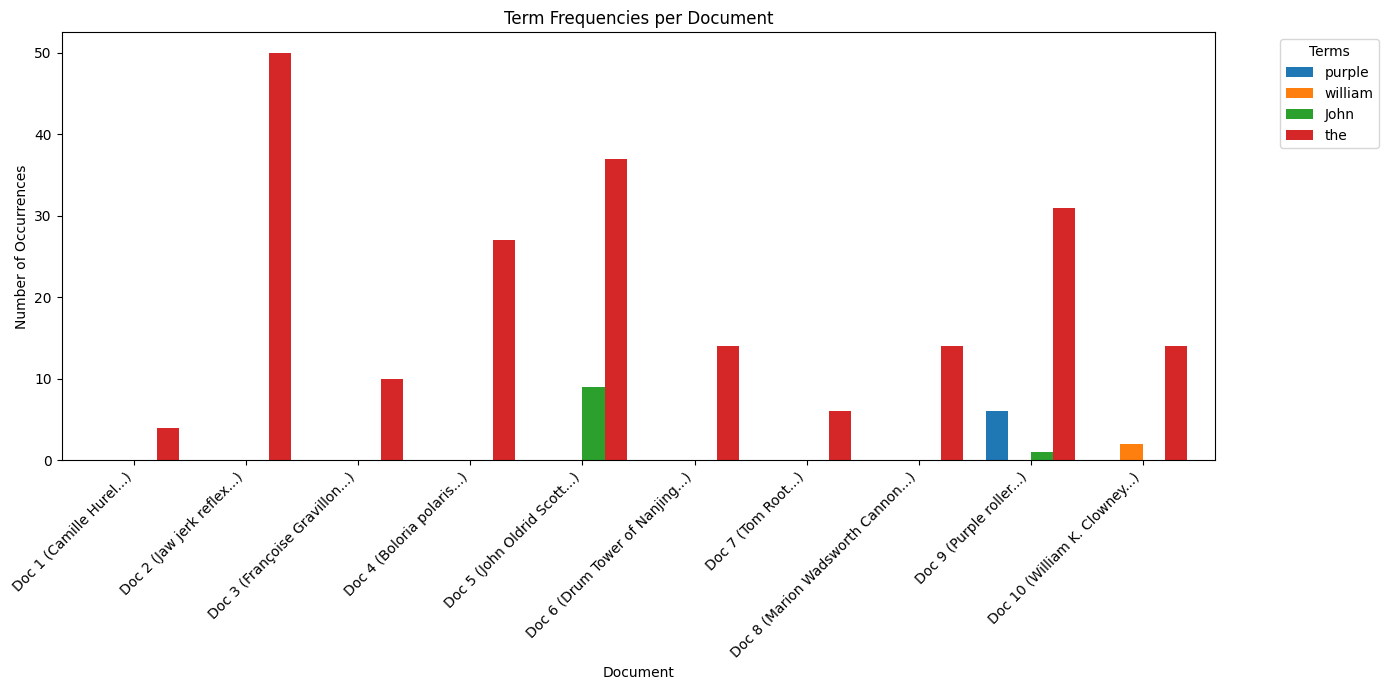


--------------------------------------------------------------------------------
TABLE 2: BM25 SCORES (Ranked by relevance)
Parameters: k1=1.6, b=0.75
--------------------------------------------------------------------------------


,Rank,Document,purple,william,John,the,Total BM25 Score
0,1,Doc 9 (Purple roller...),3.8497,0.0000,1.2532,0.1134,5.2163
1,2,Doc 10 (William K. Clowney...),0.0000,3.3413,0.0000,0.1121,3.4535
2,3,Doc 5 (John Oldrid Scott...),0.0000,0.0000,2.8962,0.1120,3.0082
3,4,Doc 2 (Jaw jerk reflex...),0.0000,0.0000,0.0000,0.1150,0.1150
4,5,Doc 4 (Boloria polaris...),0.0000,0.0000,0.0000,0.1142,0.1142
5,6,Doc 6 (Drum Tower of Nanjing...),0.0000,0.0000,0.0000,0.1128,0.1128
6,7,Doc 3 (Françoise Gravillon...),0.0000,0.0000,0.0000,0.1099,0.1099
7,8,Doc 8 (Marion Wadsworth Cannon...),0.0000,0.0000,0.0000,0.1065,0.1065
8,9,Doc 1 (Camille Hurel...),0.0000,0.0000,0.0000,0.1031,0.1031
9,10,Doc 7 (Tom Root...),0.0000,0.0000,0.0000,0.1028,0.1028



RANKING SUMMARY
1. Doc 9 (Purple roller...) - Score: 5.2163
2. Doc 10 (William K. Clowney...) - Score: 3.4535
3. Doc 5 (John Oldrid Scott...) - Score: 3.0082
4. Doc 2 (Jaw jerk reflex...) - Score: 0.115
5. Doc 4 (Boloria polaris...) - Score: 0.1142
6. Doc 6 (Drum Tower of Nanjing...) - Score: 0.1128
7. Doc 3 (Françoise Gravillon...) - Score: 0.1099
8. Doc 8 (Marion Wadsworth Cannon...) - Score: 0.1065
9. Doc 1 (Camille Hurel...) - Score: 0.1031
10. Doc 7 (Tom Root...) - Score: 0.1028

BM25 SCORE VISUALIZATION


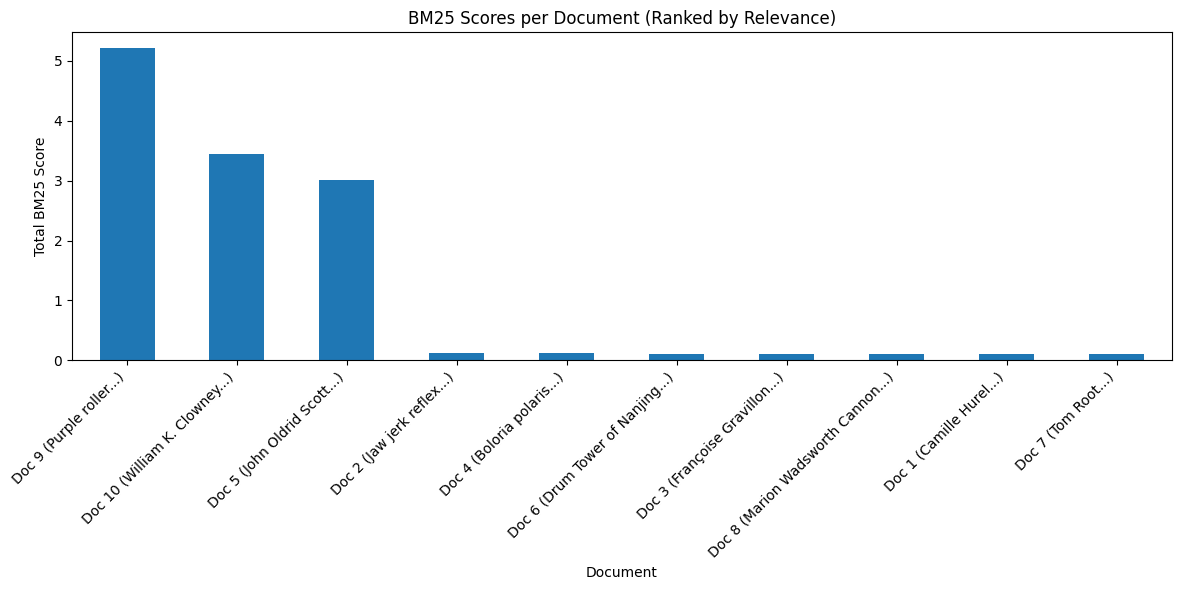



Saving BM25 results...
✓ Term frequencies: /content/drive/MyDrive/Colab Notebooks/Information Retreival/term_frequencies.csv
✓ BM25 scores: /content/drive/MyDrive/Colab Notebooks/Information Retreival/bm25_scores.csv
✓ Summary: /content/drive/MyDrive/Colab Notebooks/Information Retreival/bm25_summary.txt

✓ ALL TASKS COMPLETE!
📁 All files saved to: /content/drive/MyDrive/Colab Notebooks/Information Retreival


In [74]:
# MAIN EXECUTION
def main():
    print("=" * 60)
    print("Wikipedia Article Analyzer with BM25 Ranking")
    print("=" * 60)

    # Mount Google Drive
    print("\nMounting Google Drive...")
    drive.mount('/content/drive')

    output_path = '/content/drive/MyDrive/Colab Notebooks/Information Retreival'
    os.makedirs(output_path, exist_ok=True)
    print(f"✓ Output directory ready: {output_path}")

    # Fetch and save articles
    articles = fetch_articles(num_articles=10)

    if len(articles) == 0:
        print("\n❌ Failed to fetch any articles!")
        return

    articles_dir = f"{output_path}/articles"
    save_articles_to_files(articles, directory=articles_dir)

    # Analyze word frequencies
    most_common, total_words = analyze_word_frequency(articles, top_n=50)
    freq_file = f"{output_path}/word_frequencies.txt"
    save_word_frequencies(most_common, total_words, filename=freq_file)

    print("\n" + "=" * 60)
    print("Basic Analysis Complete!")
    print("=" * 60)
    print(f"- {len(articles)} articles saved")
    print(f"- Total words analyzed: {total_words:,}")

    # Get search terms and compute BM25
    terms = get_user_terms()
    df_tf = compute_term_frequencies(articles, terms)
    df_bm25 = compute_bm25_scores(articles, terms, k1=1.6, b=0.75)

    # Display and save results
    display_results(df_tf, df_bm25, terms)
    save_bm25_results(df_tf, df_bm25, terms, output_path)

    print("\n" + "=" * 60)
    print("✓ ALL TASKS COMPLETE!")
    print("=" * 60)
    print(f"📁 All files saved to: {output_path}")

# Run the main function
main()